In [62]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/rigel/home/ra2697/.jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update('livereveal', {
              'theme': 'white',
              'width': 1280,
              'height': 1024,
              'margin': 0.1,
})

{'height': 1024, 'margin': 0.1, 'theme': 'white', 'width': 1280}

## Petascale Postprocessing in Python

**************

#### Ryan Abernathey

## Ocean Heat Uptake

![Ocean Heat Uptake](https://static.skepticalscience.com/graphics/Nuccitelli_OHC_Data.jpg)

[Nuccitelli et al. (2012)](http://dx.doi.org/10.1016/j.physleta.2012.10.010)



## Climate Model Resolution

<img src="https://www.ipcc.ch/graphics/ar4-wg1/jpg/fig-1-4.jpg" width="250px" style="float:left; margin-right:60px">

  * Increased resolution leads to better representation of physics
  * Model codes scale relatively easily on supercomputers
  * Increases in resolution and emsemble size lead to exploding volume of data dumped to disk

<video controls src="https://svs.gsfc.nasa.gov/vis/a030000/a030500/a030552/ecco_sea_surface_speed_globe_720p.mp4" width="100%" />

Video Credit: [NASA/JPL-Caltech via NASA Scientific Visualization Studio](https://svs.gsfc.nasa.gov/30552)

## Leveraging Supercomputers for Data Analysis

![NCAR's Cheyenne supercomputer](https://www2.cisl.ucar.edu/sites/default/files/users/bjsmith/Cheyenne-450.jpg)

  * Hardware provides large, fast storage massive, parallel computing.
  * How can we take advantage of these resources?
  * Users don't want to have to learn new tools.

## Open Source Python Solution

![workflow](images/pangeo_cartoon.png)

In [3]:
import xarray as xr
from dask.dot import dot_graph
import dask.array as da
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline

import xgcm
from xmitgcm import open_mdsdataset
import xrft

In [4]:
# supress some warnings for prettier slides
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
# make xarray repr's shorter (RISE slides are very narrow)
xr.set_options(display_width=60)
# make figures big
plt.rcParams['figure.figsize'] = (10,8)

In [5]:
from dask.distributed import Client
scheduler_file = '../.dask_scheduler/dask_scheduler_file-' + os.environ['SLURM_JOBID']
client = Client(scheduler_file=scheduler_file)
client

<Client: scheduler='tcp://10.43.4.212:8786' processes=1 cores=48>

In [ ]:
ddir = '/rigel/ocp/users/ra2697/channel_topography/GCM/run_taux2000_rb0110_bump'
ds = open_mdsdataset(ddir, prefix=['U', 'Eta', 'T', 'V', 'S', 'W'])

## XArray wraps netCDF Data

In [63]:
ds

<xarray.Dataset>
Dimensions:              (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 1566)
Coordinates:
  * YG                   (YG) >f4 0.0 5000.0 10000.0 ...
  * XG                   (XG) >f4 0.0 5000.0 10000.0 ...
  * XC                   (XC) >f4 2500.0 7500.0 12500.0 ...
  * YC                   (YC) >f4 2500.0 7500.0 12500.0 ...
  * Zp1                  (Zp1) float32 0.0 -10.0 -20.0 ...
  * Zu                   (Zu) float32 -10.0 -20.0 -30.0 ...
  * Z                    (Z) float32 -5.0 -15.0 -25.0 ...
  * Zl                   (Zl) float32 0.0 -10.0 -20.0 ...
    dyC                  (YG, XC) >f4 5000.0 5000.0 ...
    Depth                (YC, XC) >f4 0.0 0.0 0.0 0.0 ...
    dyG                  (YC, XG) >f4 5000.0 5000.0 ...
    rAz                  (YG, XG) >f4 2.5e+07 2.5e+07 ...
    rAs                  (YG, XC) >f4 2.5e+07 2.5e+07 ...
    dxG                  (YG, XC) >f4 50

## XArray: Simple, Intuitive Syntax

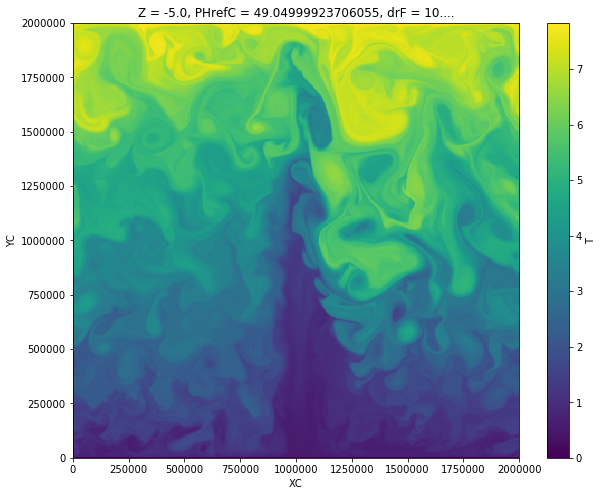

In [45]:
ds['T'].isel(time=0, Z=0).plot()

## Analysis Task: Power Spectrum

Fourier Transform:
$ v(x, t) \to \hat v(k, t) $

Wavenumber Power Spectrum:
$ \langle v^\ast v \rangle (k) $

In [49]:
# take the Fourier transform along one dimension
v_fft = xrft.dft(ds.V, dim=['XC'], shift=False)
# multiply by complex conjugate
pow_spec = (v_fft*v_fft.conj()).mean(dim=('YG','time'))
pow_spec = pow_spec.astype('f8').rename('V_power_spectrum')
pow_spec

<xarray.DataArray 'V_power_spectrum' (Z: 40, freq_XC: 400)>
dask.array<astype-..., shape=(40, 400), dtype=float64, chunksize=(40, 400)>
Coordinates:
    freq_XC_spacing  float64 5e-07
  * Z                (Z) float32 -5.0 -15.0 -25.0 -36.0 ...
  * freq_XC          (freq_XC) float64 0.0 5e-07 1e-06 ...

In [12]:
ds['V'].nbytes / 1e9 # data size in Gigabytes

40.0896

In [51]:
# make a much smaller version for visualization of the graph
nt = 14
dask_data = da.from_array(np.random.rand(nt, 400), chunks=(1,400), name='raw_data')
v = xr.DataArray(dask_data, dims=['time', 'XC'],
                 coords={'time': np.arange(nt), 'XC': np.arange(400)})
v_fft_= xrft.dft(v, dim=['XC'], shift=False, remove_mean=False)
pow_spec_ = (v_fft_*v_fft_.conj()).mean(dim=('time'))

## Visualizing the Dask Graph

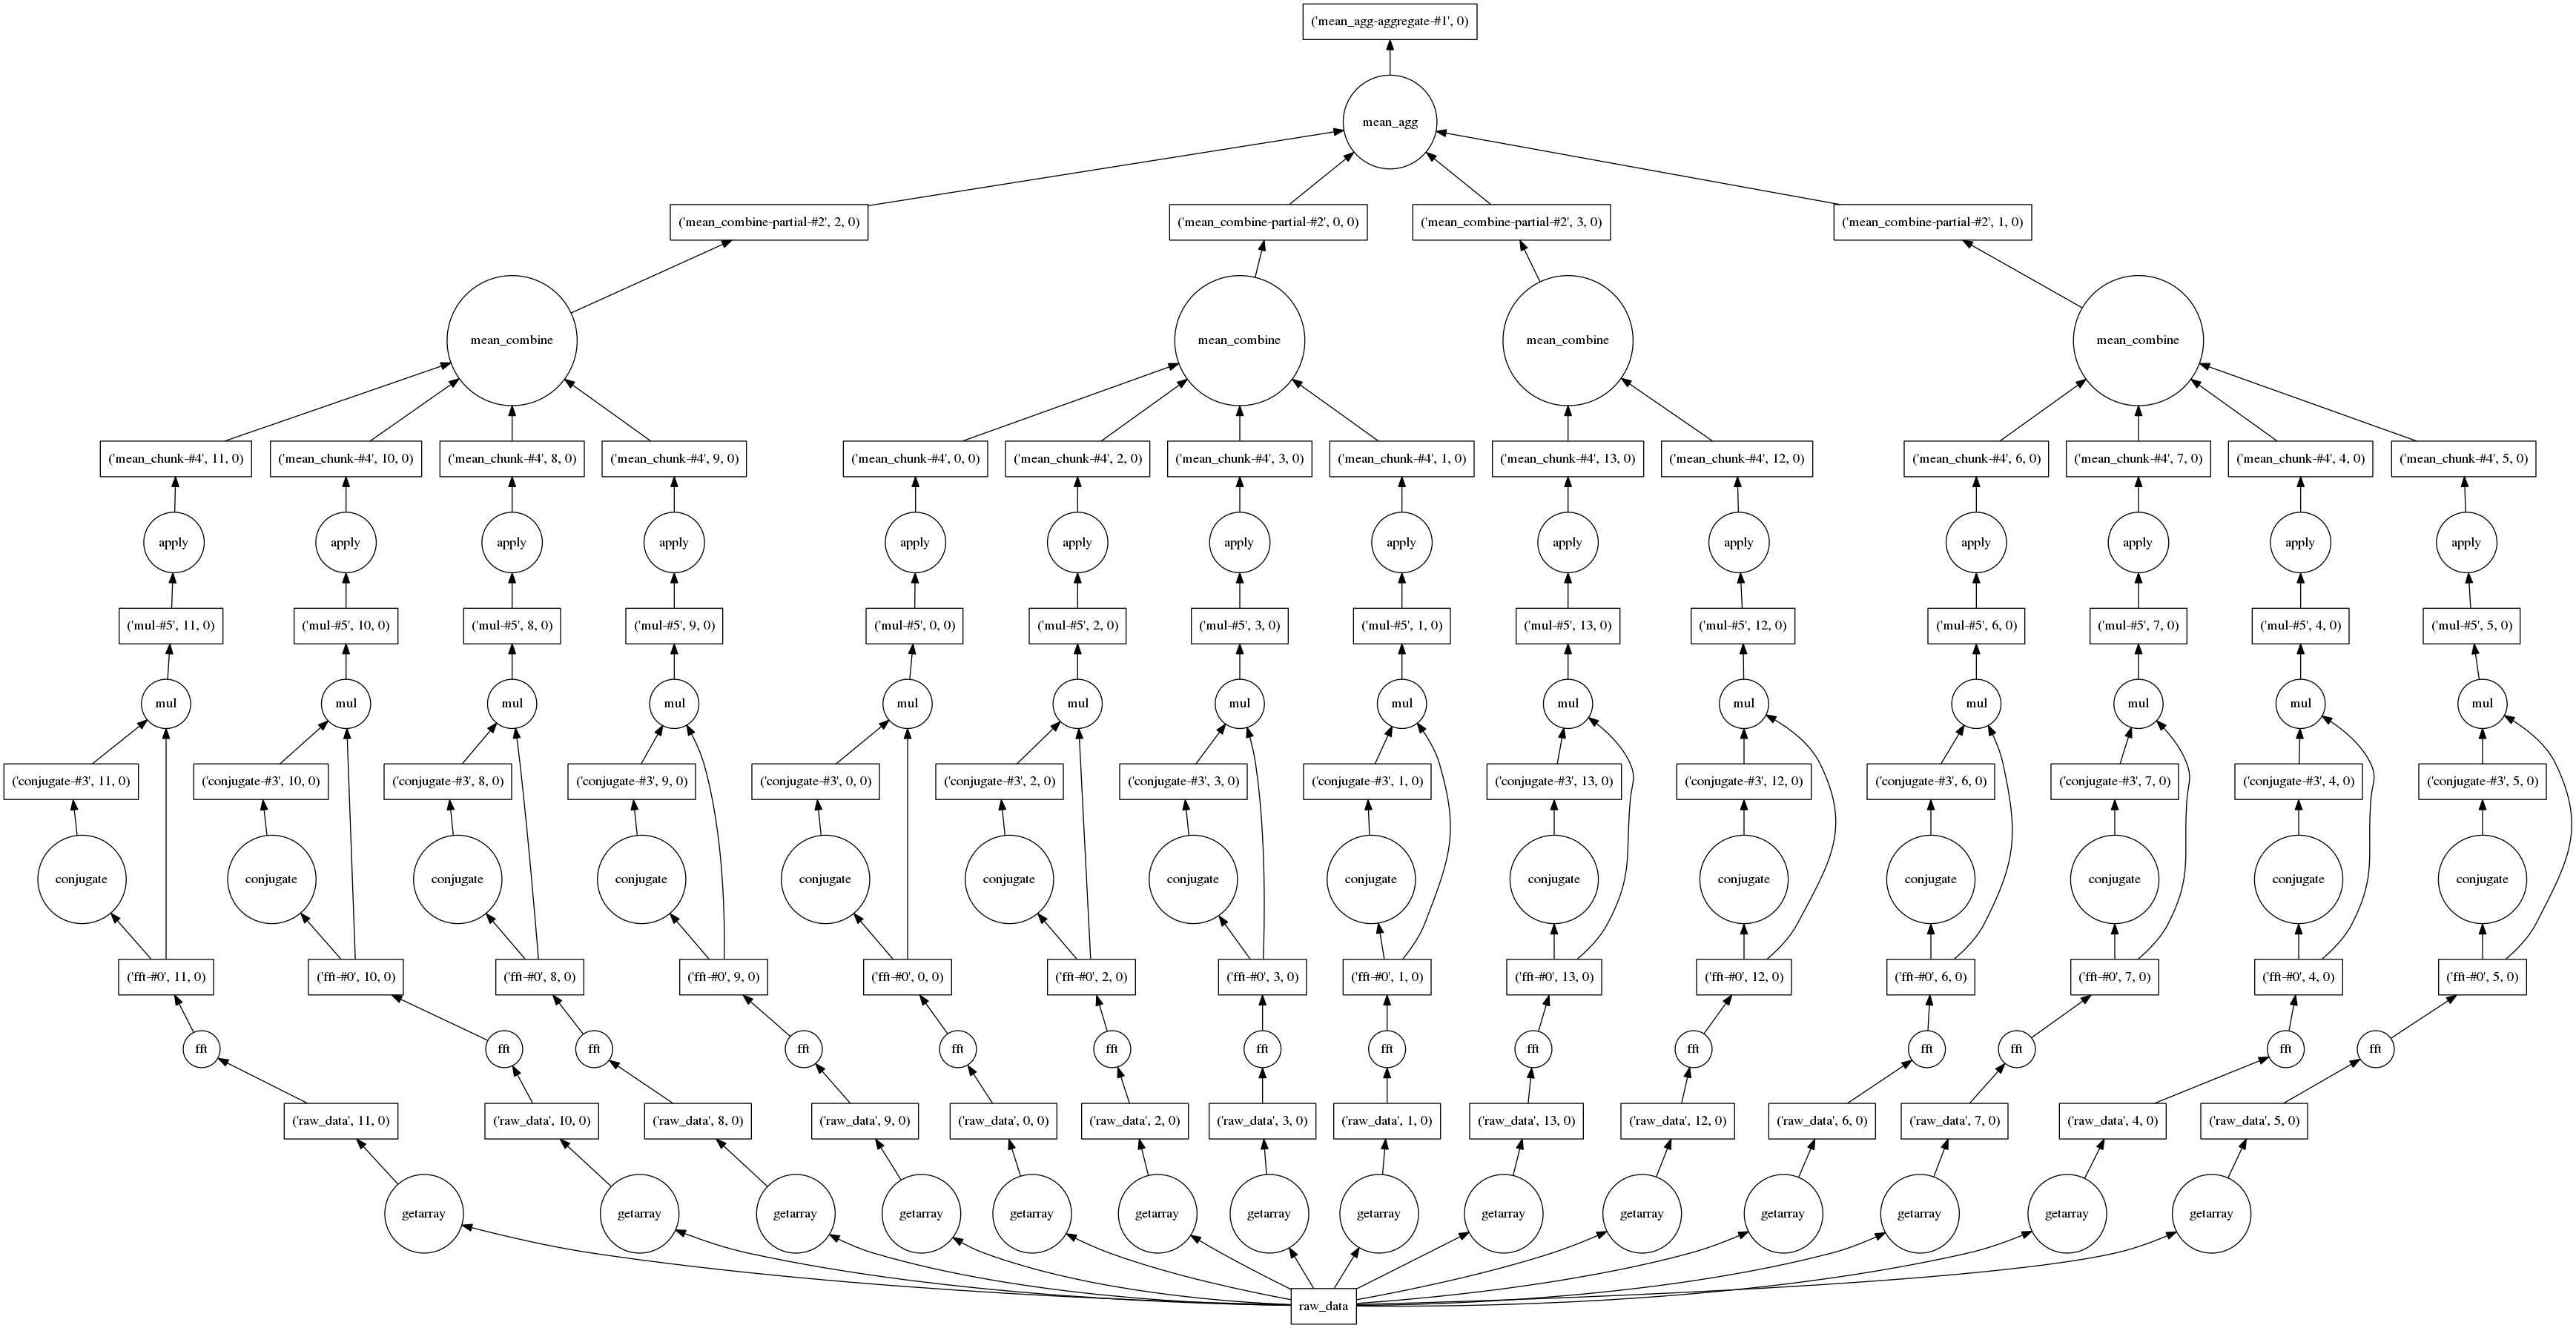

In [52]:
dot_graph(pow_spec_.data.dask)

In [57]:
pow_spec.load()

(0.01, 1000.0)

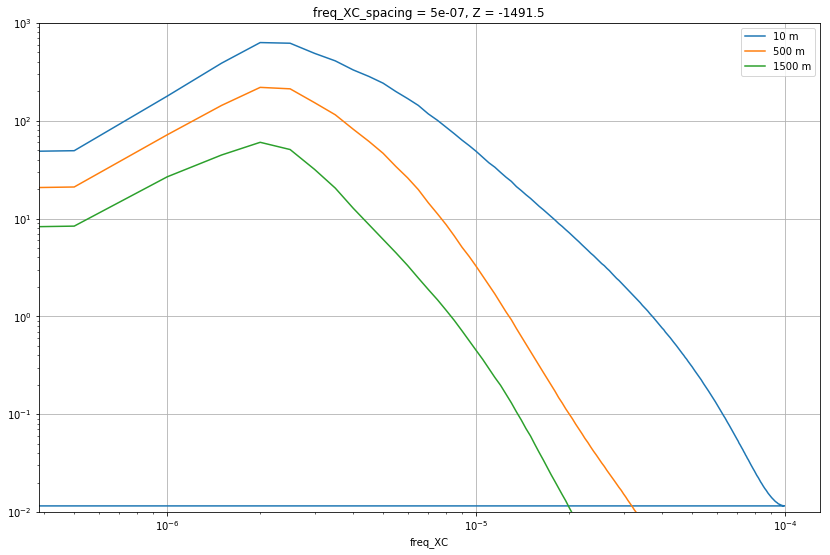

In [56]:
fig, ax = plt.subplots(figsize=(14,9))
[pow_spec.sel(Z=-z, method='nearest').plot(ax=ax, label='%g m' % (z))
 for z in [10, 500, 1500]]
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); ax.set_ylim([1e-2,1e3])

more info:
## http://pangeo-data.github.io